$$ Ahmed \space Azzam $$

$$ Churn \space Modeling$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('Churn_Modelling.csv').drop(columns = ['Surname', 'RowNumber'])

# Data Cleaning

In [3]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(data, test_size = 0.2, random_state = 2022)

In [4]:
num_cols = list(set(train_data.describe().columns.to_list()) - set(['CustomerId']))
cat_cols = list(set(train_data.columns.to_list()) - set(num_cols) - set(['CustomerId']))

In [5]:
len(num_cols)

9

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'IsActiveMember'}>],
       [<AxesSubplot:title={'center':'HasCrCard'}>,
        <AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'CreditScore'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Exited'}>]], dtype=object)

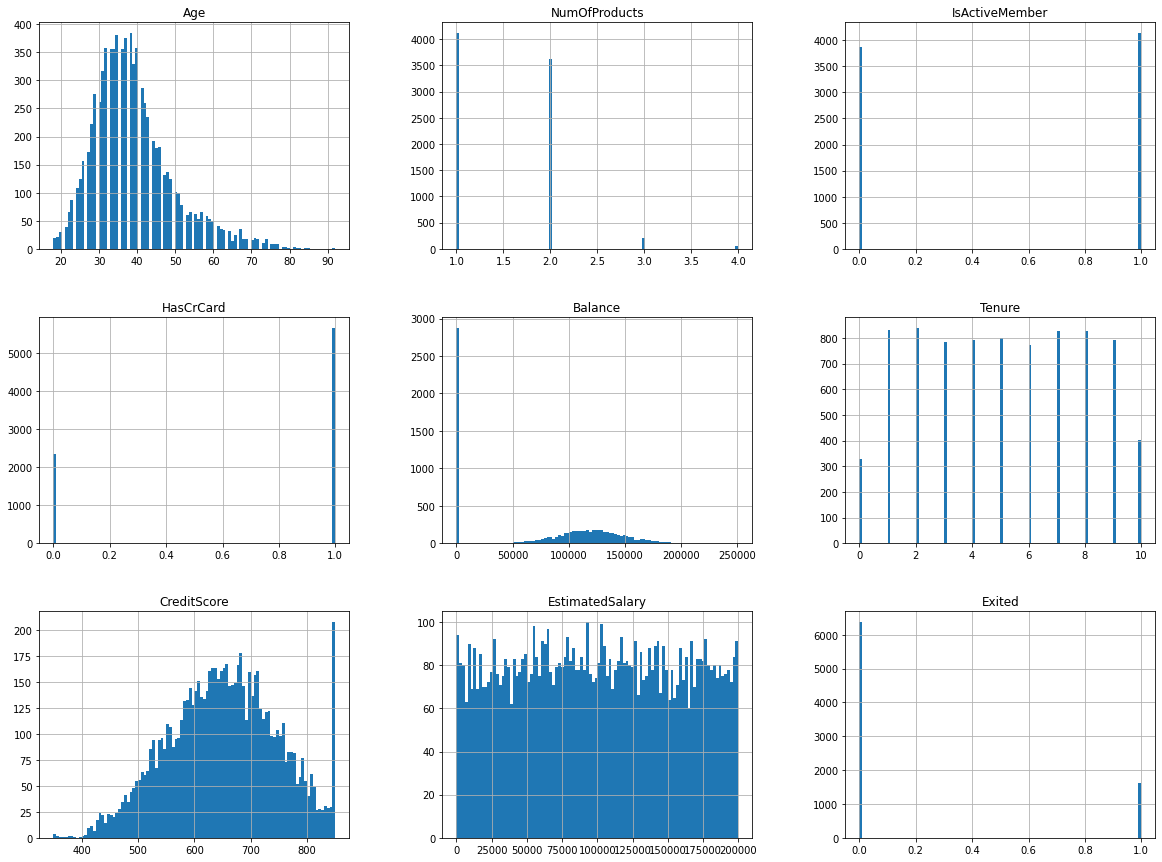

In [6]:
train_data[num_cols].hist(bins = 100, figsize = (20, 15))

In [7]:
df_list=[]
for cat_column in cat_cols:
    df_list.append(train_data.groupby([cat_column])['CustomerId'].count().reset_index().rename(columns = {'CustomerId' : 'count'}))

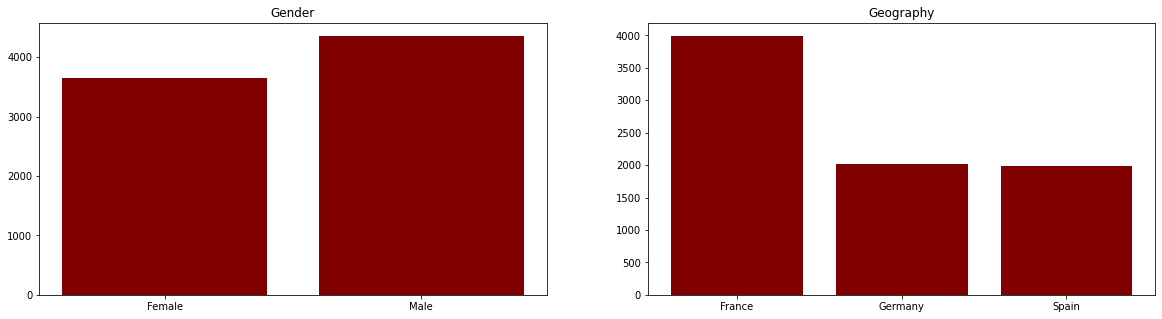

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
i=0
j=0
for df in df_list[0:10]:
    axes[j].bar(df.iloc[:, 0],df.iloc[:, 1], color ='maroon')
    axes[j].set_title(df.columns[0])
    if(j<1):
        j+=1

# Check and handel null

In [9]:
train_data.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
num_cols = list(set(train_data.describe().columns.to_list()) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))
cat_cols = list(set(train_data.columns.to_list()) - set(num_cols) - set(['CustomerId', 'HasCrCard',	'IsActiveMember', 'Exited']))

In [11]:
def check_normal_dist_shapiro(df,num_cols,alpha = 0.001):
    feats_std_scale = []
    feats_min_max_scale = []
    sample_data  = df.sample(replace = False, n= 500)
    for col in num_cols:
        stat, p = shapiro(sample_data[col])
        if p>alpha:
            feats_std_scale.append(col)
        else:
            feats_min_max_scale.append(col)
    return feats_min_max_scale,feats_std_scale

In [12]:
feats_min_max_scale,feats_std_scale=check_normal_dist_shapiro(train_data,num_cols)

In [13]:
print(feats_min_max_scale)
print(feats_std_scale)

['Age', 'NumOfProducts', 'Balance', 'Tenure', 'EstimatedSalary']
['CreditScore']


In [14]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
# fitting
min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
# transforming min_max_scale
min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
min_max_scaled_test_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)

# tranforming std_scale
std_scaled_train_data =pd.DataFrame( std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
std_scaled_test_data =pd.DataFrame( std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)

In [15]:
num_train_df = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)\
                  .merge(train_data[['HasCrCard', 'Exited', 'IsActiveMember']].reset_index(drop=True), right_index = True, left_index = True)

num_test_df = std_scaled_test_data.merge(min_max_scaled_test_data, right_index = True, left_index = True)\
                  .merge(validation_data[['HasCrCard', 'Exited', 'IsActiveMember']].reset_index(drop=True), right_index = True, left_index = True)

In [16]:
num_test_df.index

RangeIndex(start=0, stop=2000, step=1)

In [17]:
label_enc_model = LabelEncoder().fit(train_data['Gender'])
train_data['Gender'] = label_enc_model.transform(train_data['Gender'])
validation_data['Gender'] = label_enc_model.transform(validation_data['Gender'])

one_hot_enc_model = OneHotEncoder(sparse = False).fit(train_data[['Geography']])
ohe_train_data = one_hot_enc_model.transform(train_data[['Geography']])
ohe_test_data = one_hot_enc_model.transform(validation_data[['Geography']])

a=one_hot_enc_model.categories_
col_names=[]
for list_ in a:
    for element in list_:
        col_names.append(element)

nominal_train_df = pd.DataFrame(ohe_train_data, columns = col_names)
nominal_test_df = pd.DataFrame(ohe_test_data, columns = col_names)

In [18]:
nominal_train_df = nominal_train_df.merge(train_data[['Gender']].reset_index(drop=True), right_index = True, left_index = True)
nominal_test_df = nominal_test_df.merge(validation_data[['Gender']].reset_index(drop=True), right_index = True, left_index = True)

In [19]:
final_train_data = nominal_train_df.merge(num_train_df, right_index = True, left_index = True, how = 'inner')

final_test_data = nominal_test_df.merge(num_test_df, right_index = True, left_index = True, how = 'inner')

In [20]:
final_test_data.index

RangeIndex(start=0, stop=2000, step=1)

In [21]:
rare_class_data = final_train_data[final_train_data['Exited'] == 1]
dominant_class_data = final_train_data[final_train_data['Exited'] == 0]

under_sampled_class = dominant_class_data.sample(frac = 0.25, replace = False, random_state = 2022)
train_undersampled = pd.concat((under_sampled_class, rare_class_data), axis = 0)

In [22]:
# final_train_data, final_test_data
train_x = train_undersampled.drop(columns =['Exited'])
train_y = train_undersampled[['Exited']]

val_x = final_test_data.drop(columns =['Exited'])
val_y = final_test_data[['Exited']]

In [23]:
train_x

,France,Germany,Spain,Gender,CreditScore,Age,NumOfProducts,Balance,Tenure,EstimatedSalary,HasCrCard,IsActiveMember
432,0.0,1.0,0.0,1,0.156402,0.756757,0.000000,0.418905,0.7,0.230826,1,1
5171,0.0,0.0,1.0,1,-0.185353,0.189189,0.333333,0.651022,0.5,0.372054,1,1
4181,0.0,0.0,1.0,0,-0.123215,0.135135,0.000000,0.389962,0.8,0.891141,1,1
5805,0.0,0.0,1.0,1,0.011415,0.135135,0.333333,0.625049,0.8,0.991294,1,0
2392,0.0,1.0,0.0,1,-0.713519,0.108108,0.000000,0.456163,0.6,0.070357,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7977,1.0,0.0,0.0,0,-0.309627,0.432432,0.333333,0.000000,0.5,0.958816,1,0
7981,0.0,1.0,0.0,0,0.549937,0.283784,0.000000,0.496777,0.1,0.582553,1,0
7984,1.0,0.0,0.0,1,-0.651381,0.351351,0.000000,0.615428,0.8,0.246586,1,0
7989,0.0,0.0,1.0,0,1.523420,0.540541,0.333333,0.000000,0.9,0.595357,0,0


# Logistic Regression

In [24]:
def initialize(X, bias = True):
    
    if bias:
        weights = np.zeros((X.shape[1]+1,1))
        X = np.c_[np.ones((X.shape[0],1)),X]
    else:
        weights = np.zeros((X.shape[1],1))
    return weights,X

def sigmoid(z):
    sig = 1/(1 + np.e**(-z))
    return sig

def cost(X, y, theta):
    z = np.dot(X,theta)
    cost0 = y.T.dot(np.log(sigmoid(z)))
    cost1 = (1-y).T.dot(np.log(1-sigmoid(z)))
    cost = -((cost1 + cost0))/len(y) 
    return cost

def fit(X, y, lr=0.001, bias = True, max_iterations=100):
    params,X = initialize(X, bias)
    for i in range(max_iterations):
        params = params - lr * np.dot(X.T, sigmoid(np.dot(X,params)) - np.reshape(y,(len(y),1)))
    return params

def predict(X, optimum_weights, bias = True, threshold = 0.5):
    z = np.dot(initialize(X, bias)[1], optimum_weights)
    preds = []
    for i in sigmoid(z):
        if i>threshold:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [25]:
weights=fit(train_x, train_y)
# threshold should =0.66 to return 75% of churner (recall)
predictions = predict(val_x,weights,threshold=0.66)
from sklearn.metrics import accuracy_score
accuracy_score(predictions, val_y)

0.662

In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = pd.DataFrame(confusion_matrix(val_y, predictions).T).rename(columns = {0 : 'actual_not_churn', 1: 'actual_churn'})
conf_matrix

,actual_not_churn,actual_churn
0,1014,103
1,573,310


In [27]:
people_predicted_not_churn = conf_matrix.iloc[0, :].sum()
people_predicted_churn = conf_matrix.iloc[1, :].sum()

people_who_actually_not_churned = conf_matrix.sum()[0]
people_who_actually_churned = conf_matrix.sum()[1]

precision_not_churn = conf_matrix.iloc[0, 0]/people_predicted_not_churn
precision_churn = conf_matrix.iloc[1, 1]/people_predicted_churn

recall_not_churn = conf_matrix.iloc[0, 0]/people_who_actually_not_churned
recall_churn = conf_matrix.iloc[1, 1]/people_who_actually_churned

F1_score_not_churn = 2 * ((precision_not_churn * recall_not_churn)/(precision_not_churn + recall_not_churn))
F1_score_churn = 2 * ((precision_churn * recall_churn)/(precision_churn + recall_churn))

In [28]:
print('precision_not_churn: ', precision_not_churn)
print('precision_churn: ', precision_churn)
print('recall_not_churn: ', recall_not_churn)
print('recall_churn: ', recall_churn)
print('F1_score_not_churn: ', F1_score_not_churn)
print('F1_score_churn: ', F1_score_churn)

precision_not_churn:  0.9077887197851388
precision_churn:  0.3510758776896942
recall_not_churn:  0.6389413988657845
recall_churn:  0.7506053268765133
F1_score_not_churn:  0.75
F1_score_churn:  0.4783950617283951


In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression( fit_intercept= True,C=0.66).fit(train_x, train_y)

y_pred_sklearn = model.predict(val_x)

accuracy_score(y_pred_sklearn, val_y)

C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7125

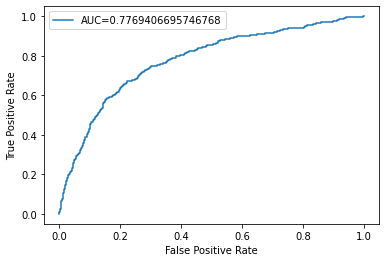

In [30]:
from sklearn import metrics
y_pred_proba = model.predict_proba(val_x)[::, 1]
fpr, tpr, thresholds = metrics.roc_curve(val_y, y_pred_proba)
auc = metrics.roc_auc_score(val_y, y_pred_proba)
#create ROC curve showing in the bottom the AUC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=2)
plt.show()

# SVC

In [31]:
from sklearn import svm
C_list=[0.01,0.1,1,10,100,200]
F1_score=list()
for i in C_list:
    clf = svm.SVC(kernel='linear',C=i)
    clf.fit(train_x,train_y)
    y_pred_sklearn=clf.predict(val_x)
    F1_score.append(accuracy_score(y_pred_sklearn, val_y))


C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

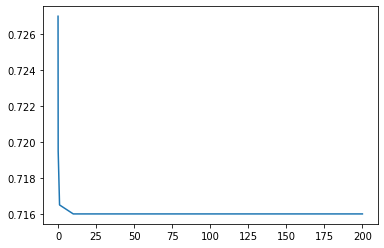

In [32]:
plt.plot(C_list,F1_score)
# plt.xticks(C_list)
# plt.yticks(F1_score)
plt.show()

In [33]:
F1_score_2=list()
for i in C_list:
    clf = svm.SVC(kernel='poly',C=i)
    clf.fit(train_x,train_y)
    y_pred_sklearn=clf.predict(val_x)
    F1_score_2.append(accuracy_score(y_pred_sklearn, val_y))

C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [34]:
F1_score_2

[0.5475, 0.691, 0.739, 0.769, 0.772, 0.773]

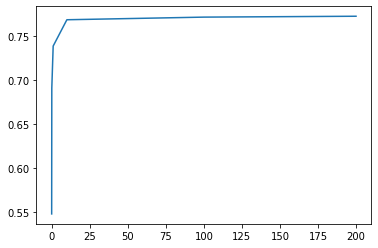

In [35]:
plt.plot(C_list,F1_score_2)
# plt.xticks(C_list)
# plt.yticks(F1_score)
plt.show()

In [36]:
F1_score_3=list()
for i in C_list:
    clf = svm.SVC(kernel='rbf',C=i)
    clf.fit(train_x,train_y)
    y_pred_sklearn=clf.predict(val_x)
    F1_score_3.append(accuracy_score(y_pred_sklearn, val_y))

C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ahmed Atef\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [37]:
F1_score_3

[0.633, 0.667, 0.731, 0.7535, 0.735, 0.725]

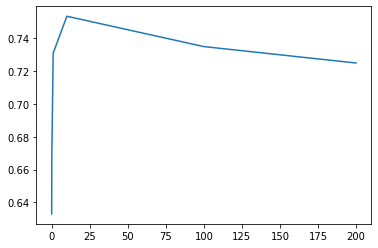

In [38]:
plt.plot(C_list,F1_score_3)
# plt.xticks(C_list)
# plt.yticks(F1_score)
plt.show()

---------------

$$ Submitted \space by: \space Ahmed \space Azzam $$